## Imports

In [6]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer


/opt/anaconda3/envs/otakutag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loader

In [3]:
raw_data_path = os.path.join("..","data","cleaned","clean_combined_data.csv")

df = pd.read_csv(raw_data_path)

df.head()

,Title,Synopsis,Action,Adventure,Boys Love,Comedy,Drama,Ecchi,Erotica,Fantasy,Girls Love,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One Punch Man,The seemingly unimpressive Saitama has a rathe...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kimetsu no Yaiba,"Ever since the death of his father, the burden...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Sword Art Online,Ever since the release of the innovative Nerve...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Generate Backup 
df_backup_1 = df.copy()

In [5]:
# Load Backup 
df = df_backup_1.copy()

## Pre-Processing & Tokenization

### Transformer-Based Models (PyTorch + Hugging Face) + ULMFiT (FastAI)
These models use **subword tokenization** (e.g., WordPiece, Byte-Pair Encoding) and are powerful for NLP tasks.

| **Model**              | **Tokenizer** | **Max Tokens** | **Strengths** | **Weaknesses** |
|------------------------|--------------|---------------|--------------|---------------|
| **BERT (bert-base-uncased)** | WordPiece | 512 | General-purpose, bidirectional context, good for sentence-level tasks. | Limited to 512 tokens, slow training. |
| **DistilBERT (distilbert-base-uncased)** | WordPiece | 512 | 40% fewer parameters than BERT, faster inference. | Slightly lower accuracy than BERT. |
| **RoBERTa (roberta-base)** | Byte-Pair Encoding (BPE) | 512 | Trained on more data than BERT, better generalization. | Needs more GPU memory than DistilBERT. |
| **ALBERT (albert-base-v2)** | SentencePiece | 512 | Compressed BERT with shared parameters, faster training. | Some accuracy trade-offs. |
| **XLNet (xlnet-base-cased)** | SentencePiece | 512 | Uses permutation-based learning, good for long sequences. | More complex training, slow inference. |
| **Longformer (allenai/longformer-base-4096)** | Byte-Pair Encoding (BPE) | 4,096 | Handles long documents, sliding window attention. | Expensive to train, high VRAM usage. |
| **GPT-2 (gpt2)** | Byte-Pair Encoding (BPE) | 1,024 | Strong generative capabilities, good for text completion. | Unidirectional, may not work well for classification. |
| **T5 (t5-small)** | SentencePiece | 512 | Can handle multiple NLP tasks (classification, summarization, translation). | Needs task-specific tuning, larger models are VRAM-intensive. |
| **BART (facebook/bart-base)** | Byte-Pair Encoding (BPE) | 1,024 | Seq2Seq-based transformer, good for summarization & text classification. | Requires more computational resources. |
| **ULMFiT (AWD-LSTM - fastai)** | FastAI/Spacy Tokenizer | No fixed limit | Good for small datasets, efficient training. | Not as powerful as transformers, may struggle with unseen words. |

In [61]:
# Find average and max token length

# Load your dataset
df_test = df_backup_1.copy()

# Choose a wordpiece tokenizer from Hugging Face for data preprocessing
MODEL_NAME = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize the synopsis column and get lengths
token_lengths = df_test["Synopsis"].dropna().apply(lambda x: len(tokenizer.tokenize(x)))

# Compute max and average token lengths
max_length = token_lengths.max()
avg_length = token_lengths.mean()

print(f"Max Token Length: {max_length}")
print(f"Average Token Length: {avg_length}")


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


Max Token Length: 1001
Average Token Length: 103.47926452242773


In [62]:
# We can convert token_lengths to a DataFrame and use the hist method to plot a histogram of the token lengths.
token_df = pd.DataFrame(token_lengths)
token_df.columns = ["Token Length"]
token_df.describe()

,Token Length
count,92185.000000
mean,103.479265
std,77.633858
min,1.000000
25%,39.000000
50%,94.000000
75%,150.000000
max,1001.000000


**Observation:** 

Since 3rd STD value is 150 , safe to say most summaries are short. 

Since there seem to be some outliars , we need to remove them to 

make the df compatible for 512 token based models . 


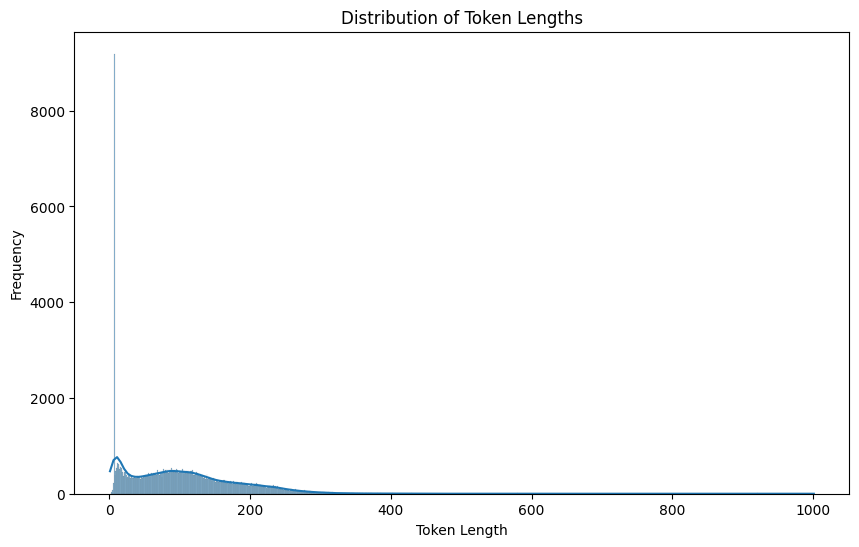

In [63]:
# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
sns.histplot(token_df["Token Length"], bins="auto", kde=True, discrete=True)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()


**Observation:**

It seems like we have a very large peak near 10 . 

It looks unnatural for the kind of work we are doing. 

I need to zoom in a little bit . 

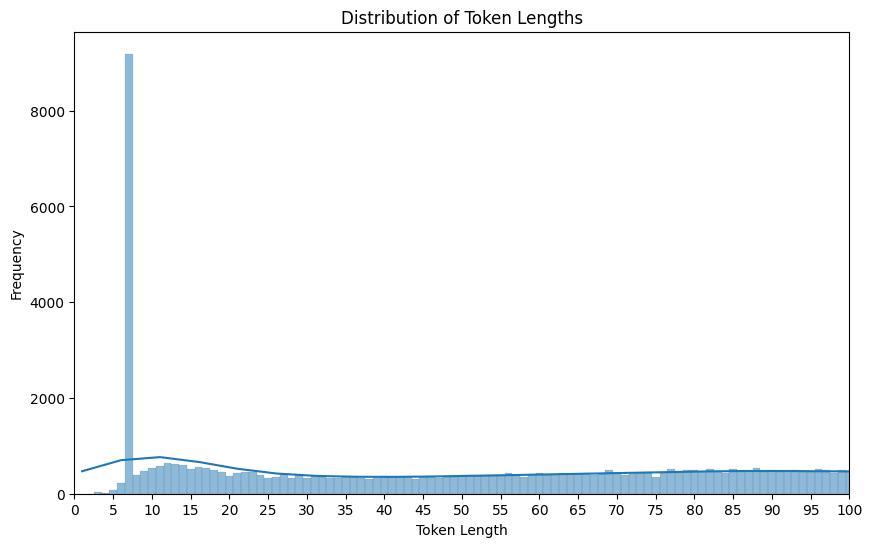

In [65]:
# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
sns.histplot(token_df["Token Length"], bins="auto", kde=True, discrete=True)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

# Set x-axis limits to zoom in
plt.xlim(0, 100)  # Adjust the range as needed

# Add more indicator points on the x-axis
plt.xticks(np.arange(0, 101, 5))  # Adjust the step size as needed

plt.show()


**Observation:**

Looks like the peak is at token size 7 . 

so we need to see what that sentance actually is that is repeating so many times 

In [ ]:
# Apply tokenizer to get token lengths and filter rows with exactly 7 tokens
synopsis_with_7_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) == 7)

# Get the original synopses that have exactly 7 tokens
original_synopsis_with_7_tokens = df_test[synopsis_with_7_tokens].copy()

                                          Title  \
444                             One Punch Man 3   
916                       Spy x Family Season 3   
934                         Dandadan 2nd Season   
995        Shinmai Maou no Testament Departures   
1033           Overlord Movie 1: Fushisha no Ou   
...                                         ...   
92175                     Zettaiaku no Kaibutsu   
92178  Eiyuu to Hanzai-ou no Kikan: RE:Criminal   
92182                       Onga: Phantom Video   
92189            Tomoshibijima no Pandora Shark   
92193                       Houkago Stray Sheep   

                             Synopsis  Action  Adventure  Boys Love  Comedy  \
444    Third season of One Punch Man.     1.0        0.0        0.0     1.0   
916     Third season of Spy x Family.     1.0        0.0        0.0     1.0   
934        Second season of Dandadan.     1.0        0.0        0.0     1.0   
995                (No synopsis yet.)     1.0        0.0        0.0    

In [82]:
percent_of_sus_data=(original_synopsis_with_7_tokens.shape[0]/(df_test.shape[0]+ original_synopsis_with_7_tokens.shape[0]))*100

print(f"Percentage of data with 7 tokens: {percent_of_sus_data:.2f}%")

Percentage of data with 7 tokens: 8.98%


In [79]:
original_synopsis_with_7_tokens.iloc[:40, :2]

,Title,Synopsis
444,One Punch Man 3,Third season of One Punch Man.
916,Spy x Family Season 3,Third season of Spy x Family.
934,Dandadan 2nd Season,Second season of Dandadan.
995,Shinmai Maou no Testament Departures,(No synopsis yet.)
1033,Overlord Movie 1: Fushisha no Ou,First Overlord recap film.
1038,Strike the Blood IV,Fourth season of Strike the Blood.
1060,Overlord Movie 2: Shikkoku no Eiyuu,Second Overlord recap film.
1354,Break Blade Movie 6: Doukoku no Toride,Sixth and final Break Blade movie.
1559,Cencoroll Connect,The sequel to Cencoroll.
1577,Strike the Blood Final,Fifth season of Strike the Blood.


**Observation:**

From the looks of it,the synopsis with data such as (No Synopsis yet.) and "nth Season of X anime" 

Are of no use for the classification , so we need to find a threshold where the token size indicates

useful synopsis. 

In [ ]:
synopsis_with_32_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) == 32)
original_synopsis_with_32_tokens = df_test[synopsis_with_32_tokens].copy()

In [ ]:
original_synopsis_with_32_tokens.iloc[:40, :2]

,Title,Synopsis
1052,Chuunibyou demo Koi ga Shitai! Depth of Field:...,Specials bundled with the first season's BD/DV...
1892,Toaru Majutsu no Index-tan Movie: Endymion no ...,Bonus animation featuring Index-tan included w...
2935,All That Gundam,Animated video created just for a 1989 event t...
3028,Kyoukaisenjou no Horizon Special,The Blu-ray Box set of Kyoukaisenjou no Horizo...
3061,Cobra The Animation: Time Drive,Lady has disappeared so Cobra must dive into h...
3269,Ku Pao Ying Xiong,The animation tells the story of Xiao Shuai wh...
3289,Bari Bari Densetsu (1987),The film is about 4 high-schoolers who are bik...
3431,Super Robot Taisen OG: Divine Wars - Sorezore ...,This is considered episode 26 of the series wh...
3650,Aru Zombie Shoujo no Sainan PV,Promotional video for an anime adaptation of t...
3775,Kung Fu Liaoli Niang,"A young, starving traveler finds himself in th..."


In [96]:
synopsis_with_less_than_32_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) < 31)
original_synopsis_with_less_than_32_tokens = df_test[synopsis_with_less_than_32_tokens].copy()

percent_less_than_32_token=(original_synopsis_with_less_than_32_tokens.shape[0]/(df_test.shape[0]+ original_synopsis_with_less_than_32_tokens.shape[0]))*100

print(f"Original data size: {df_test.shape[0]}")
print(f"Data size with less than 31 tokens: {original_synopsis_with_less_than_32_tokens.shape[0]}")
print(f"Percentage of data with less than 31 tokens: {percent_less_than_32_token:.2f}%")
print(f"Total data size after filtering: {df_test.shape[0] - original_synopsis_with_less_than_32_tokens.shape[0]}")

Original data size: 93144
Data size with less than 31 tokens: 21151
Percentage of data with less than 31 tokens: 18.51%
Total data size after filtering: 71993


71,993 is still plenty of data for our task. 

**Observation:**

Token size of 32 and above seems to contain synopsis with useful information 

for classification . So we will only keep the data that is greater or equal 

to 32 tokens and less than or equal to 512 tokens. 

In [98]:
MAX_TOKENS = 512
MIN_TOKENS = 32

# Function to safely tokenize and handle non-strings
def get_token_length(text):
    try:
        # Ensure the input is a string before tokenizing
        return len(tokenizer.tokenize(str(text)))
    except Exception as e:
        # Handle any potential issues (e.g., non-string values)
        print(f"Error tokenizing text: {text}, {e}")
        return 0  # Default length for error cases

# Compute token lengths for all "Synopsis" entries, ensuring non-null values
mask = df["Synopsis"].notna() & (df["Synopsis"].apply(get_token_length) <= MAX_TOKENS) & (df["Synopsis"].apply(get_token_length) >= MIN_TOKENS)

# Filter rows where the token length is within the min and max limits
df_filtered_tokens = df[mask].copy()  # Avoids SettingWithCopyWarning

# Print summary
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered_tokens)}")

Original dataset size: 93144
Filtered dataset size: 71548


In [100]:
df_filtered_tokens.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71548 entries, 0 to 92196
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          71548 non-null  object 
 1   Synopsis       71548 non-null  object 
 2   Action         70904 non-null  float64
 3   Adventure      70904 non-null  float64
 4   Boys Love      70904 non-null  float64
 5   Comedy         70904 non-null  float64
 6   Drama          70904 non-null  float64
 7   Ecchi          70904 non-null  float64
 8   Erotica        70904 non-null  float64
 9   Fantasy        70904 non-null  float64
 10  Girls Love     70904 non-null  float64
 11  Horror         70904 non-null  float64
 12  Mystery        70904 non-null  float64
 13  Romance        70904 non-null  float64
 14  Sci-Fi         70904 non-null  float64
 15  Slice of Life  70904 non-null  float64
 16  Sports         70904 non-null  float64
 17  Supernatural   70904 non-null  float64
 18  Suspense   

**Observation:**

From the looks of it, there are rows with empty target values i.e. genre value .

So we need to drop those now . 

In [102]:
# List of genre columns
genre_columns = [
    "Action", "Adventure", "Boys Love", "Comedy", "Drama", "Ecchi", 
    "Erotica", "Fantasy", "Girls Love", "Horror", "Mystery", 
    "Romance", "Sci-Fi", "Slice of Life", "Sports", "Supernatural", "Suspense"
]

# Drop rows where all genre columns are null
df_cleaned = df_filtered_tokens.dropna(subset=genre_columns, how='all')

# Check the result
print(f"Previous dataset size: {len(df_filtered_tokens)}")
print(f"Cleaned dataset size (after dropping rows with all genre nulls): {len(df_cleaned)}")

Previous dataset size: 71548
Cleaned dataset size (after dropping rows with all genre nulls): 70904


In [104]:
print(df_cleaned.head())
df_cleaned.info()

                              Title  \
0                Shingeki no Kyojin   
1  Fullmetal Alchemist: Brotherhood   
2                     One Punch Man   
3                  Kimetsu no Yaiba   
4                  Sword Art Online   

                                            Synopsis  Action  Adventure  \
0  Centuries ago, mankind was slaughtered to near...     1.0        0.0   
1  After a horrific alchemy experiment goes wrong...     1.0        1.0   
2  The seemingly unimpressive Saitama has a rathe...     1.0        0.0   
3  Ever since the death of his father, the burden...     1.0        0.0   
4  Ever since the release of the innovative Nerve...     1.0        1.0   

   Boys Love  Comedy  Drama  Ecchi  Erotica  Fantasy  Girls Love  Horror  \
0        0.0     0.0    1.0    0.0      0.0      0.0         0.0     0.0   
1        0.0     0.0    1.0    0.0      0.0      1.0         0.0     0.0   
2        0.0     1.0    0.0    0.0      0.0      0.0         0.0     0.0   
3        0

Let's see the status of our Generes after the final touch up with our data . 

Based on these values, we need to decide and select various data samplaing and training 

techniques to confonsate for the imbalance of data.   

In [107]:
genre_columns = df_filtered_tokens.columns[2:] 

genre_counts = df_filtered_tokens[genre_columns].sum()

genre_counts = genre_counts.sort_values(ascending=False)

print(genre_counts)

Action           23830.0
Comedy           23174.0
Fantasy          22237.0
Romance          17996.0
Drama            17720.0
Adventure        15923.0
Supernatural     12399.0
Sci-Fi           12166.0
Slice of Life     7502.0
Boys Love         7309.0
Mystery           6600.0
Erotica           6444.0
Ecchi             4466.0
Horror            4068.0
Girls Love        2494.0
Suspense          1996.0
Sports            1663.0
dtype: float64


## Model Training  

| **Model**                | **Size**            | **Speed**                   | **Memory Requirements**  | **Reason to Choose** | **Why Not** |
|--------------------------|---------------------|-----------------------------|--------------------------|----------------------|-------------|
| **BERT (bert-base-uncased)** | Medium (110M parameters) | Slow to moderate           | High (~12GB for fine-tuning) | Popular, well-supported for classification tasks | High memory requirements for training |
| **DistilBERT (distilbert-base-uncased)** | Smaller (66M parameters) | Faster than BERT           | Moderate (~8GB for fine-tuning) | Faster and lighter version of BERT, good for resource-constrained setups | Slightly lower accuracy than full BERT |
| **RoBERTa (roberta-base)** | Large (125M parameters) | Slow to moderate           | High (~13GB for fine-tuning) | Improved BERT architecture, good for NLP tasks | High memory usage, slower processing |
| **ALBERT (albert-base-v2)** | Small (12M parameters) | Fast                       | Low (~5GB for fine-tuning)  | Efficient, reduces model size, still effective for NLP | Somewhat lower accuracy compared to BERT and RoBERTa |
| **XLNet (xlnet-base-cased)** | Large (110M parameters) | Slow to moderate           | High (~12GB for fine-tuning) | Great for NLP tasks, powerful but complex | Higher memory usage, slower inference |
| **Longformer (allenai/longformer-base-4096)** | Large (125M parameters) | Moderate                   | High (~12GB for fine-tuning) | Best for long sequences (large token window) | Not ideal for short data (like 512 tokens max) |
| **GPT-2 (gpt2)** | Large (124M parameters) | Moderate                   | High (~12GB for fine-tuning) | Good for generative tasks, less suited for classification | Not designed for classification, slower for non-generative tasks |
| **T5 (t5-small)** | Small (60M parameters) | Moderate                   | Moderate (~8GB for fine-tuning) | Good for text generation and translation tasks, flexible | Not as optimized for classification tasks |
| **BART (facebook/bart-base)** | Large (140M parameters) | Moderate                   | High (~13GB for fine-tuning) | Good for sequence-to-sequence tasks, robust for text generation | High memory usage, slower inference |
| **ULMFiT (AWD-LSTM - fastai)** | Medium (50M parameters) | Fast                       | Moderate (~8GB for fine-tuning) | Works well with transfer learning, fast training, optimized for smaller datasets | May not perform as well as transformer-based models |

Recommended Models for my system:

1. **DistilBERT**:
   - **Why**: It’s a smaller, faster, and more memory-efficient version of BERT with nearly the same performance. Given our data (70K samples, 512 tokens), it will balance speed and performance on our system well.

2. **ALBERT**:
   - **Why**: ALBERT’s architecture is more efficient, requiring less memory while maintaining good performance. It is ideal for my MacBook with 24GB of RAM, especially if we're looking for faster training.

3. **T5 (t5-small)**:
   - **Why**: It’s smaller and more efficient, suitable for text generation and classification tasks. It will run well on our setup with moderate memory consumption.

**Avoid/Consider for Larger Models**:

- **BERT, RoBERTa, XLNet, BART**:
  - **Why Not**: These models are more resource-heavy and would require significant GPU/CPU power and memory for fine-tuning, which may cause slower processing times on our system. If memory is an issue, these models might be a challenge for training with our data size.

### Data Sampling techniques 

The probelm we are solving is multi-label classification . 

The data that we have, even after cleain is not perfect . 

So we need to take help of statistical decision making to aid 

the model steer into the direction we want it to take . 

#### **Which Model Techniques We Need and Why?**  

| **Technique**                                      | **Needed?** | **Why?**  |
|----------------------------------------------------|------------|----------|
| **1. Weighted Binary Cross-Entropy Loss**         | ✅ Yes     | You have some imbalanced genres (e.g., **Suspense (1996)** vs. **Action (23830)**). Without weighting, the model might focus too much on frequent genres, ignoring rare ones. Weighted BCE ensures minority labels contribute fairly to the loss.  |
| **2. Focal Loss**                                  | ❌ No      | Your dataset isn't extremely imbalanced. Focal Loss is useful when **minority labels are extremely rare (e.g., <1% of total data)**, which isn't the case here. Weighted BCE should be enough.  |
| **3. Threshold Tuning for Multi-Label Classification** | ✅ Yes     | Since multi-label classification isn't a simple "highest probability wins" problem, setting the right threshold per genre is **critical** to avoid over/under-predicting labels. This improves the F1-score. |

---

### **Sampling Techniques (During Training)**  

| **Technique**                                      | **Needed?** | **Why?**  |
|----------------------------------------------------|------------|----------|
| **1. Stratified Sampling**                         | ✅ Yes     | If you train in **random batches**, some batches may lack rare genres. Stratified sampling ensures each batch contains diverse labels, helping the model learn from underrepresented genres.  |
| **2. MixUp / CutMix Augmentation**                | ❌ No      | These techniques are **more suited for vision tasks** (e.g., images). In text, mixing two different synopses could confuse the model rather than help it learn meaningful genre relationships. |

### **Final Recommendations**:
✅ Use **Weighted BCE Loss**  
✅ Apply **Threshold Tuning**  
✅ Implement **Stratified Sampling**  

This setup ensures your model fairly learns all genres while handling class imbalance effectively! 🚀